# Syria Twitter Data Processing, Visualization, and NLP Analysis 


What are the word patterns and hashtags that the tweeter uses? How do these change over time? What sites do they link to? What words appear around others? Who or what do they talk about?
* Obtain and clean the data from a Twitter user’s timeline
* Export into a csv file and a Python dictionary
* Apply analysis tools from NLTK to get summary data and explore hypotheses about the user’s tweets
* Use Python libraries to visualize the data you collect

## About the dataset
I'm a huge fan of open-source projects and giving back to the community. In my first blog post of this series, I talked about contacting individuals and companies for datasets. Through research, I was lucky to connect with an individual located in Finland named Daniel Zautner. Daniel has previously researched Syria's rebel communities on Twitter and analyzed the CIA's TOW anti-tank missiles program. The CIA orchestrated a plan to provided missiles to rebel groups, and in return, the rebels had to upload a video of themselves using the weapon to YouTube. You can read more about the program [here](https://www.wsj.com/articles/covert-cia-mission-to-arm-syrian-rebels-goes-awry-1422329582) and [here](https://www.washingtonpost.com/world/national-security/syrian-opposition-fighters-obtain-us-made-tow-anti-tank-missiles/2014/04/16/62d1a6f6-c4e8-11e3-b574-f8748871856a_story.html?utm_term=.c416c128e21a). Daniel was able help assist me with my research and provided me with his Twitter dataset. I especially want to say thank you Daniel for his help, and I hope we're able to meet in the future over drinks or a coffee.

All of the code shown in this tutorial lives on Github. The Jupyter Notebook in the repo includes all of the text from this blog post, with some slight modifications.


In [6]:
# import core libraries 
import datetime
import json
import csv
import ast
import pathlib
import pprint
import itertools
from collections import Counter
from itertools import islice

# import third-party libraries
import lxml.html
import pandas
from pandas.io.json import json_normalize
from pandas import ExcelWriter

# import visualizations
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [7]:
test= {'created_at': 'Thu Jul 06 01:40:18 +0000 2017', 'id': 8.827761843790152e+17, 'id_str': '882776184379015168', 'text': '"Hate preacher\' who has been living inUK 4 2 years \'produced 3-part vid series telling...how 2wage terror in Syria\'" https://t.co/qKVld6Wyuv', 'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'truncated': False, 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 2845849081.0, 'id_str': '2845849081', 'name': 'ARnews 1936', 'screen_name': 'ARnews1936', 'location': 'ISRAEL', 'url': 'https://web.telegram.org/#/im?p=@arnews1936', 'description': 'Shalom, I am Israeli zionist, I tweet news from the Middle East and around the world, Patriot, Pro-USA| Retweet≠endorsement | Unfollow=Block', 'protected': False, 'verified': False, 'followers_count': 101004, 'friends_count': 76519, 'listed_count': 617, 'favourites_count': 9484, 'statuses_count': 72001, 'created_at': 'Wed Oct 08 03:02:03 +0000 2014', 'utc_offset': 10800, 'time_zone': 'Jerusalem', 'geo_enabled': True, 'lang': 'en', 'contributors_enabled': False, 'is_translator': False, 'profile_background_color': '0099B9', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme4/bg.gif', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme4/bg.gif', 'profile_background_tile': False, 'profile_link_color': '0099B9', 'profile_sidebar_border_color': '5ED4DC', 'profile_sidebar_fill_color': '95E8EC', 'profile_text_color': '3C3940', 'profile_use_background_image': True, 'profile_image_url': 'http://pbs.twimg.com/profile_images/859119983565185024/3SDcAQGp_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/859119983565185024/3SDcAQGp_normal.jpg', 'profile_banner_url': 'https://pbs.twimg.com/profile_banners/2845849081/1415398498', 'default_profile': False, 'default_profile_image': False, 'following': None, 'follow_request_sent': None, 'notifications': None}, 'geo': None, 'coordinates': None, 'place': None, 'contributors': None, 'is_quote_status': False, 'retweet_count': 38, 'favorite_count': 24, 'entities': {'hashtags': [], 'urls': [{'url': 'https://t.co/qKVld6Wyuv', 'expanded_url': 'http://www.dailymail.co.uk/news/article-4668784/Hate-preached-produced-three-video-series-jihad.html', 'display_url': 'dailymail.co.uk/news/article-4…', 'indices': [117, 140]}], 'user_mentions': [], 'symbols': []}, 'favorited': False, 'retweeted': False, 'possibly_sensitive': False, 'filter_level': 'low', 'lang': 'en'}

pprint.pprint(test)

{'contributors': None,
 'coordinates': None,
 'created_at': 'Thu Jul 06 01:40:18 +0000 2017',
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [{'display_url': 'dailymail.co.uk/news/article-4…',
                        'expanded_url': 'http://www.dailymail.co.uk/news/article-4668784/Hate-preached-produced-three-video-series-jihad.html',
                        'indices': [117, 140],
                        'url': 'https://t.co/qKVld6Wyuv'}],
              'user_mentions': []},
 'favorite_count': 24,
 'favorited': False,
 'filter_level': 'low',
 'geo': None,
 'id': 8.827761843790152e+17,
 'id_str': '882776184379015168',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': None,
 'possibly_sensitive': False,
 'retweet_count': 38,
 'retweeted': False,
 'source': '<a href="http://twitter.com" rel

In [2]:
# set directory path data
twitter_data_dir = pathlib.Path('/Users/adamstueckrath/Desktop/twitter_data/')

# set tweets_json_path path
tweets_json = twitter_data_dir / 'tweets' / 'tweets.json'


In [3]:
# new line json streamer for processing the data -> MAIN FUNCTION FOR ANALYSIS
# json objects must be stored per line, not in an arrary 
# my dataset contains separate JSON object on each line
def nljson_generator(json_path):
    with open(json_path) as file:
        for line in file: 
            yield json.loads(line)

# get the total number of tweet json objects in dataset
def count_tweet_objects(json_path):
    count = 0
    for tweet in nljson_generator(json_path): 
        count+=1
    return count

# read n number of json objects from the tweets dataset
def get_n_tweets(json_path, n_tweets):
    data = []
    for line in islice(nljson_generator(json_path), n_tweets):
        data.append(line)
    return(data)  


### Total count of tweets and a sample of column attributes

In [4]:
# print out the length of the json file
# count_tweet_dataset = count_tweet_objects(tweets_json)
# print('Total count of tweets {}'.format(count_tweet_dataset))

# print column attributes
# tweet_normalize = json_normalize(sample_tweets)
# print(tweet_normalize.columns.tolist())

There’s a lot of text here, and much of it is not specific to the tweet itself. For example, since we’re grabbing all metadata of a user's account, the majority of the `"user"` attribute isn't very useful to us for this analysis. Instead, it is just noise and extra data every time.

In [5]:
# removes retweets by checking the text of the tweet and if it starts with 'RT'
# writes original tweets to a new json file, line-delimited
def remove_retweets(json_path, output_json_path):
    with open(output_json_path, 'w', encoding='utf-8') as output:
        for tweet in nljson_generator(json_path):
            text = tweet['text']
            if text.startswith('RT'):
                continue
            else:
                json.dump(tweet, output)
                output.write("\n")
                

##  Reformat the json data as a csv
In this step, I'm going to condense and clean the data to get it into a more analysis-friendly format. I want to be able to load my entire dataset into a pandas dataframe for easier interpretation. In order to do that, I need to format and structure my data. Therefore, I'm going to be writing data to a csv. Some notes about why I chose to write to my json data to a csv:

* A lot of people like seeing the data all at once as a csv — there are neat ways to print it in Python but this is easier to absorb
* Csv is a great format to use if you need to share the data with people who don’t program as they can open it up in any notepad or spreadsheet program, no coding required
* If you want to continue the analysis with Python but in a different project file, you can always use the dictionary or read in a csv in a couple of lines of code

### Identify tweet attributes for analysis
I'm going identify all important attributes for this project and list them below. This will be a part of the data cleaning/processing section. I referenced the Twitter API official documentation to understand all of the fields and identify what information I want to pull from each tweet. Here's the link: https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object

**Twitter Tweet Attributes** <br /> 
Tweets are the basic atomic building block of all things Twitter. Tweets are also known as “status updates.” 
* `created_at`: UTC time when this Tweet was created.
* `id`: The integer representation of the unique identifier for this Tweet. 
* `id_str`: The string representation of the unique identifier for this Tweet.
* `text`: The actual UTF-8 text of the tweet.
* `source`: Utility used to post the Tweet as an HTML-formatted string.
* `retweet_count`: Number of times the tweet was retweeted.
* `favorite_count`: Number of times the tweet was favorited.
* `lang`: When present, indicates a BCP 47 language identifier corresponding to the machine-detected language of the Tweet text, or `und` if no language could be detected. 
* `coordinates`: Represents the geographic location of this Tweet as reported by the user or client application.
* `geo`: This deprecated attribute has its coordinates formatted as [lat, long], while all other Tweet geo is formatted as [long, lat].
* `place`: When present, indicates that the tweet is associated (but not necessarily originating from)

**Twitter User Attributes** <br />
The `user` object contains public Twitter account metadata and describes the account.
* `name`: The name of the user, as they’ve defined it.
* `screen_name`: The screen name, handle, or alias that this user identifies themselves with.
* `location`: The user-defined location for this account’s profile. 
* `verified`: When true, indicates that the user has a verified account.
* `followers_count`: The number of followers this account currently has. 
* `utc_offset`: To calculate the time relative to the user's timezone.

**Twitter Tweet Entities Attributes** <br /> 
The `entities` section provides arrays of common things included in Tweets: hashtags, user mentions, links, stock tickers (symbols), Twitter polls, and attached media.
* `hashtags`: Represents hashtags which have been parsed out of the Tweet text. (e.g. "#Syria" appears as "Syria")
* `user_mentions`: Represents other Twitter users mentioned in the text of the Tweet. 
* `media`: Represents media elements uploaded with the Tweet. 
* `type`: The actual type of media is specified in the media.
* `url`: the expanded version of urls included in the tweet (e.g. "https://t.co/ljRAxRICTr" is the shortened URL in the tweet and the full url is https://www.nytimes.com/reuters/2017/03/21/world/middleeast/21reuters-israel-syria-iran.html)
* `title`: HTML title for the link.
* `description`: HTML description for the link.


In [101]:
# data cleaning functions 
def clean_hashtags(tweet_hashtags):
    """
    Turns data with any number of hashtags like this:
    'hashtags': [{'text': 'FAKENEWS', 'indices': [80, 89]}]
    to a list like this -> ['FAKENEWS']
    """
    hashtags_cleaned = []
    if len(tweet_hashtags) >= 1:
        for tag in range(len(tweet_hashtags)):
            hashtag_text = tweet_hashtags[tag]['text'].lower()
            hashtags_cleaned.append(hashtag_text)
    return hashtags_cleaned

def clean_source(source):
    """
    Turns data including the source and some html like this:
    <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a> 
    to a string like this -> 'Twitter for Android'
    """
    try:
        raw = lxml.html.document_fromstring(source)
        raw = raw.text_content()
    except:
        return None
    return raw

def string_to_datetime(tweet_date):
    """
    Turns a datetime string like this: 
    '2017-07-06T18:34:37.000Z' 
    to a Python datetime object like this -> 2017-07-06 18:34:41
    """
    return datetime.datetime.strptime(tweet_date, "%Y-%m-%dT%H:%M:%S.%fZ")


def clean_user_mentions(user_mentions):
    """
    Turns data like this:
    [{'screen_name': 'TheSwogBlog', 'name': 'The Swog Blog', 'id': 7.130089490967429e+17, 
    'id_str': '713008949096742912', 'indices': [0, 12]}]
    into to a list -> ['TheSwogBlog']
    """
    user_mentions_cleaned = []
    if len(user_mentions) >= 1:
        for user in range(len(user_mentions)):
            mention = user_mentions[user]['screen_name']
            user_mentions_cleaned.append(mention)
    return user_mentions_cleaned

def clean_geo_and_coordinates(tweet_geo_or_coordinates):
    """
    Extracts elements of a dictionary like:  
    {'type': 'Point', 'coordinates': [35.3612, 31.3893]}
    into a list like this -> [35.3612, 31.3893]
    """
    tweet_coordinates = None
    if tweet_geo_or_coordinates:
        tweet_coordinates = tweet_geo_or_coordinates['coordinates']
    return tweet_coordinates

def clean_places(tweet_place):
    """
    Extracts elements of a dictionary like:  
    {'id': '65b23b0045f450f6', 'url': 'https://api.twitter.com/1.1/geo/id/65b23b0045f450f6.json', 
    'place_type': 'city', 'name': 'Kingston upon Thames', 'full_name': 'Kingston upon Thames, London', 
    'country_code': 'GB', 'country': 'United Kingdom', 
    'bounding_box': {'type': 'Polygon', 'coordinates': [[[-0.322917, 51.34286], 
    [-0.322917, 51.437266], [-0.234011, 51.437266], [-0.234011, 51.34286]]]}, 'attributes': {}}
    
    Returns a tuple of the dictionary elements: 
    ('city', 'Kingston upon Thames', 'Kingston upon Thames, London', 'GB', 'United Kingdom', 'Polygon', 
    [[-0.322917, 51.34286], [-0.322917, 51.437266], [-0.234011, 51.437266], [-0.234011, 51.34286]])
    
    """
    place_type = name = full_name = country_code = None
    country = bounding_box_type = bounding_box_coordinates = None

    if tweet_place:
        place_type = tweet_place['place_type']
        name = tweet_place['name']
        full_name = tweet_place['full_name']
        country_code = tweet_place['country_code']
        country = tweet_place['country']
        bounding_box_type = tweet_place['bounding_box']['type']
        bounding_box_coordinates = tweet_place['bounding_box']['coordinates'][0]
    
    return place_type, name, full_name, country_code, \
           country, bounding_box_type, bounding_box_coordinates

def clean_entities_url(tweet_entities):
    """
    Extracts the expanded url from a dictionary like:  
    [{'url': 'https://t.co/Eiqt4Gu4hs', 'expanded_url': 'https://twitter.com/i/web/status/883031529303232512', 
    'display_url': 'twitter.com/i/web/status/8…', 'indices': [121, 144]}]
    To a string like this -> 'https://twitter.com/i/web/status/883031529303232512'
    """
    tweet_entities_urls_expanded_url = None
    if tweet_entities['urls']:
        tweet_entities_urls_expanded_url = tweet_entities['urls'][0]['expanded_url']
    return tweet_entities_urls_expanded_url

def clean_extended_entities(tweet):
    """
    Extracts elements of the tweet extended_entities attribute like:  
    {'expanded_url': 'https://twitter.com/Reuters/status/883028019266281472/video/1', 'type': 'video'}
    """
    tweet_extended_entities_media_type = None
    tweet_extended_entities_media_url = None
    tweet_extended_entities = tweet.get('extended_entities', None)
    if tweet_extended_entities:
        tweet_entended_entities_media = tweet_extended_entities.get('media', None)
        if tweet_entended_entities_media:
            tweet_extended_entities_media_type = tweet_entended_entities_media[0]['type']       
            tweet_extended_entities_media_url = tweet_entended_entities_media[0]['expanded_url']
    return tweet_extended_entities_media_type, tweet_extended_entities_media_url


In [102]:
# write twitter data to flatten csv file
def write_tweets_to_csv(tweets_json, outfile):
    # the headers are the fields that we identified in step 4
    headers = ['tweet_id', 'tweet_id_str', 'tweet_created_at', 'tweet_geo', 'tweet_coordinates', 
               'place_type', 'place_name', 'place_full_name', 'place_country', 'place_country_code',
               'bounding_box_type', 'bounding_box_coordinates', 'tweet_lang', 
               'tweet_source', 'tweet_text', 'tweet_retweet_count', 'tweet_favorite_count', 
               'user_id_str', 'user_screen_name', 'user_name', 'user_location', 'user_utc_offset', 
               'user_verified', 'user_followers_count', 'tweet_hashtags', 'tweet_user_mentions', 
               'tweet_expanded_url', 'tweet_media_type', 'tweet_media_url']
    
    # here we create the file and write the header row with the headers list
    # note that the 'filename' argument will be the name of the csv file
    with open(outfile, mode='w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(headers)
        
        for tweet in nljson_generator(tweets_json):
            # tweet attributes
            tweet_id = tweet['_id']['$oid']
            tweet_id_str = tweet['id_str']
            tweet_date = tweet['created_at']['$date']
            tweet_geo = clean_geo_and_coordinates(tweet['geo'])
            tweet_coord = clean_geo_and_coordinates(tweet['coordinates'])
            tweet_place_type, tweet_place_name, \
            tweet_place_full_name, tweet_place_country_code, \
            tweet_place_country, tweet_place_bounding_box_type, \
            tweet_place_bounding_box_coordinates = clean_places(tweet['place'])
            tweet_lang = tweet['lang']
            tweet_source = clean_source(tweet['source'])
            tweet_text = tweet['text']
            tweet_retweet_count = tweet['retweet_count']
            tweet_favorite_count = tweet['favorite_count']
            # tweet user attributes
            tweet_user_id_str = tweet['user']['id_str']
            tweet_user_name = tweet['user']['name']
            tweet_user_screen_name = tweet['user']['screen_name']
            tweet_user_location = tweet['user']['location']
            tweet_user_utc_offset = tweet['user']['utc_offset']
            tweet_user_verified = tweet['user']['verified']
            tweet_user_followers_count = tweet['user']['followers_count']
            # tweet entities attributes
            tweet_extended_entities_media_type = None
            tweet_extended_entities_media_url = None
            tweet_extended_entities = tweet.get('extended_entities', None)
            if tweet.get('retweeted_status', None):
                
            tweet_entities = tweet['entities']
            tweet_entities_hashtags = clean_hashtags(tweet_entities['hashtags'])
            tweet_entities_user_mentions = clean_user_mentions(tweet_entities['user_mentions'])
            tweet_entities_urls_expanded_url = clean_entities_url(tweet_entities)
            tweet_extended_entities_media_type, tweet_extended_entities_media_url = clean_extended_entities(tweet)
            
            writer.writerow([tweet_id, tweet_id_str, tweet_date, tweet_geo, tweet_coord, tweet_place_type, 
                             tweet_place_name,tweet_place_full_name, tweet_place_country_code, tweet_place_country,
                             tweet_place_bounding_box_type, tweet_place_bounding_box_coordinates, tweet_lang, 
                             tweet_source, tweet_text, tweet_retweet_count, tweet_favorite_count,
                             tweet_user_id_str, tweet_user_screen_name, tweet_user_name, tweet_user_location, tweet_user_utc_offset,
                             tweet_user_verified, tweet_user_followers_count, tweet_entities_hashtags, 
                             tweet_entities_user_mentions, tweet_entities_urls_expanded_url, 
                             tweet_extended_entities_media_type, tweet_extended_entities_media_url])
            

In [ ]:
    tweet_extended_entities_media_type = None
    tweet_extended_entities_media_url = None
    tweet_extended_entities = tweet.get('extended_entities', None)
    if tweet_extended_entities:
        tweet_entended_entities_media = tweet_extended_entities.get('media', None)
        if tweet_entended_entities_media:
            tweet_extended_entities_media_type = tweet_entended_entities_media[0]['type']       
            tweet_extended_entities_media_url = tweet_entended_entities_media[0]['expanded_url']
    return tweet_extended_entities_media_type, tweet_extended_entities_media_url


In [103]:
# tweets_no_rts_csv file path
tweets_no_rts_csv = twitter_data_dir / 'tweets_no_retweets' / 'tweets_no_retweets.csv'

# write tweets to csv 
# write_tweets_to_csv(tweets_no_rts_json, tweets_no_rts_csv)

## Exploring and visualizing the dataset
Getting a high level understanding of what's actually in the data set is usually my first step. Let's start by getting a qualitive view of what we have before we dive into the text. There's a mix of quantitative tools for this step and NLTK features for looking at the text.

Here are my steps:
1. Load  clean dataset into a data frame to  summarize the main characteristics of a dataset.
2. Generate visualizations to quickly and simply view most of the relevant features of the dataset.
  * What is our timeframe?
  * Top users by followers?
  * Top hashtags by count?
  * Top sources used to send tweets?
3. Identify variables that are likely to have interesting observations.

In [104]:
# load tweets into dataframe from csv file
tweets_no_rts_df = pandas.read_csv(tweets_no_rts_csv, header=0,
                                   parse_dates=['tweet_created_at'], 
                                   date_parser=string_to_datetime)


In [105]:
# print dataframe
tweets_no_rts_df.head()


,tweet_id,tweet_id_str,tweet_created_at,tweet_geo,tweet_coordinates,place_type,place_name,place_full_name,place_country,place_country_code,...,user_name,user_location,user_utc_offset,user_verified,user_followers_count,tweet_hashtags,tweet_user_mentions,tweet_expanded_url,tweet_media_type,tweet_media_url
0,595e82d713bbf01307babbbd,883031462043414528,2017-07-06 18:34:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Gab.ai ➡,NaN,-10800.0,False,306,[],"['Autumblues', 'JudeStevens', 'CBCNews']",NaN,NaN,NaN
1,595e82d713bbf01307babbc0,883031476706717698,2017-07-06 18:34:44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Turkey America,NaN,NaN,False,0,[],[],https://www.nytimes.com/reuters/2017/03/21/wor...,NaN,NaN
2,595e82d713bbf01307babbc1,883031487859351552,2017-07-06 18:34:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Turkey America,NaN,NaN,False,0,[],[],https://www.nytimes.com/aponline/2017/03/21/wo...,NaN,NaN
3,595e82d713bbf01307babbc6,883031512031125505,2017-07-06 18:34:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,WakeUP2017,NaN,NaN,False,12713,['fakenews'],['Diane1hDiane'],https://twitter.com/i/web/status/8830315120311...,NaN,NaN
4,595e82d713bbf01307babbc7,883031514803560448,2017-07-06 18:34:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Turkey America,NaN,NaN,False,0,[],[],https://www.washingtonpost.com/world/europe/sy...,NaN,NaN


### Tweet Dates Timeframe
Let's take a look at the timeline of our dataset. What is the dates and the counts over time in data? What events happened during the time frame?

In [106]:
# group tweet dates and counts
tweet_dates_group_df = tweets_no_rts_df['tweet_created_at'] \
                       .groupby([tweets_no_rts_df.tweet_created_at.dt.date]) \
                       .agg('count')


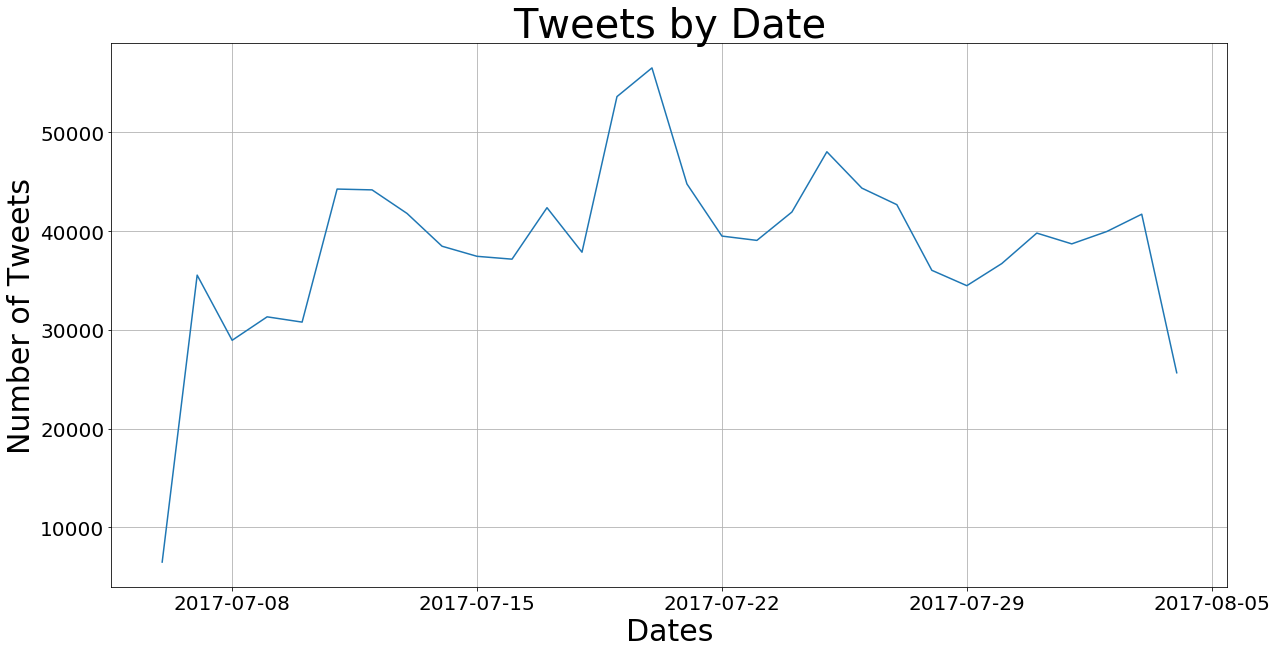

In [313]:
# plot the grouped dates
tweet_dates_group_df.plot(kind="line", figsize=(20, 10))
plt.title('Tweets by Date', size = 40)
plt.ylabel('Number of Tweets', size = 30)
plt.yticks(size=20)
plt.xlabel('Dates', size = 30)
plt.xticks(size=20)
plt.grid(True)
plt.savefig('/Users/adamstueckrath/Desktop/tweet_timeframe.png')
plt.show()

Here's a list of events that happened during this timeframe: <br /> 

**July 2017**
* `1 July` Syrian Army forces fully recapture the quarries area west of Baath City in Quneitra reversing all rebel gains during the offensive.
* `4 July` A fifth round of talks organized by Russia, Turkey and Iran takes place in Astana, Kazakhstan discussing the implementation of safe zones in Syria.
* `11 July` The Syrian Observatory of Human rights confirm the death of Abu Bakr al-Baghdadi, the leader of the Islamic State.
* `14 July` Syrian Arab Army claims that Free Syrian Army commander of Regiment 107 is killed by a roadside bomb planted by the SAA in Daraa.
* `23 July` According to the Syrian Observatory for Human Rights, the Syrian government carried out several airstrikes in Eastern Ghouta, in violation of the cessation of hostilities it had declared on the previous day.
* `24 July` The Russian General Staff announced the introduction of new "de-escalation zones" in Syria, including in the north of the city of Homs and in East Ghouta region.
* `26 July` A FSA military commander of the Syrian Revolutionaries Front, Bashair al-Numairi, is targeted and killed by a IED at the road between the towns of Zimrin and Um Al-Uosaj in northern Daraa, Syria.
* `29 July` The Islamic State of Iraq and the Levant loses 6,000 square kilometers during the first month of the 4th year of its creation. 
* `31 July` According to the Syrian Network for Human Rights, the Syrian government dropped 244 barrel bombs in July, in the "de-escalation zones", targeting Daraa governorate, the Damascus suburbs, Suwayda, Hama and Homs.

**August 2017**
* `3 August` The Syrian government shells rebel towns in Eastern Ghouta.
* `4 August` Nearly 8,000 Syrian refugees and fighters arrived in rebel-held central Syria from Lebanon as part of a ceasefire deal between Hezballah and Fateh al-Sham.


## Top tweet sources
In this part we are going to check the source of the tweets. And by the “source” I mean the device the tweet was sent from. As usual the first step is the cleaning. The kind of device is situated at the end in the column called `tweet_source`. With the following example we can see what the device is.


In [108]:
# get the top tweet sources
tweets_by_source = tweets_no_rts_df['tweet_source'].value_counts()
tweets_by_source = tweets_by_source.sort_values(ascending=False)[:10]


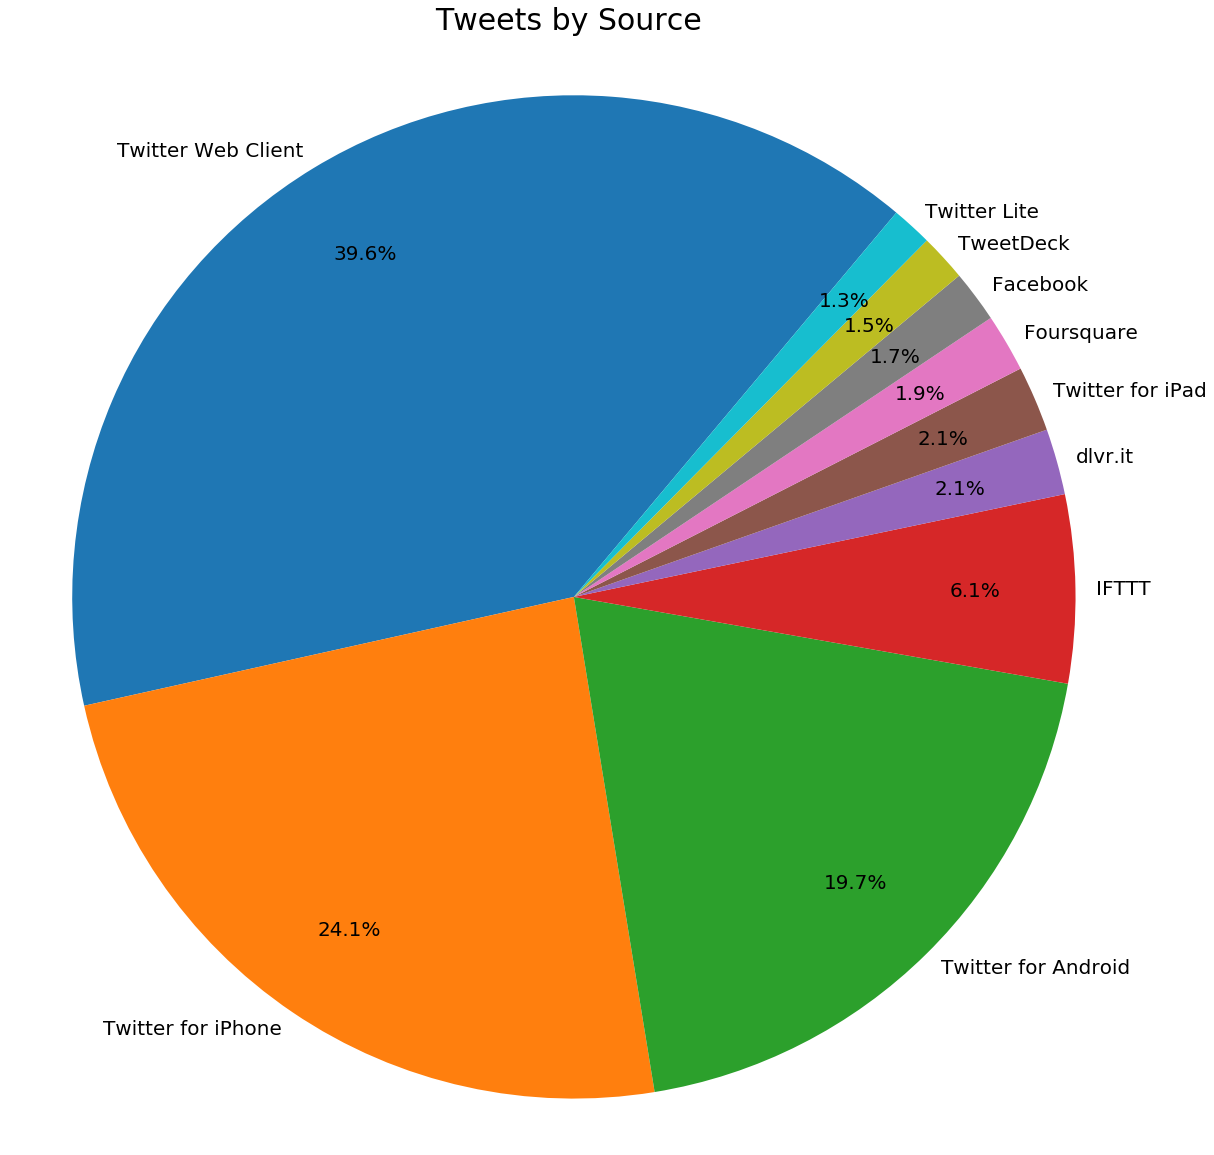

In [314]:
# plot the top tweet sources 
fig, ax = plt.subplots(figsize=(20, 20))
ax.pie(tweets_by_source, labels=tweets_by_source.index, autopct='%1.1f%%', startangle=50, 
       textprops={'fontsize': 20}, labeldistance=1.04, pctdistance=0.8, rotatelabels=False)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal') 
plt.title('Tweets by Source', size = 30, y=1.02)
plt.savefig('/Users/adamstueckrath/Desktop/top_tweet_sources.png')
plt.show()


This chart shows us that the most important part of the tweet is sent through the Twitter Web Client, iPhone, and Android, and less than 3% by Instagram and other devices. I noticed that IFTTT makes up about 6% of devices, which I'd never heard of until now.

**What is IFTTT?** <br /> 
It's named from the programming conditional statement “if this, then that.” What the company provides is a software platform that connects apps, devices and services from different developers in order to trigger one or more automations involving those apps, devices and services. This is really surprising to me and could be indicator of Twitter bots.


## Top Tweet hashtags

In [110]:
# get top hashtags
top_hashtags_df = pandas.DataFrame(tweets_no_rts_df, 
                                   columns=['tweet_hashtags'])
top_hashtags_df['tweet_hashtags'] = top_hashtags_df['tweet_hashtags'].apply(lambda x: ast.literal_eval(x))
top_hashtags_list = top_hashtags_df['tweet_hashtags'].tolist()
top_hashtags_list = list(itertools.chain.from_iterable(top_hashtags_list))
top_n_hashtags = Counter(top_hashtags_list).most_common(20)


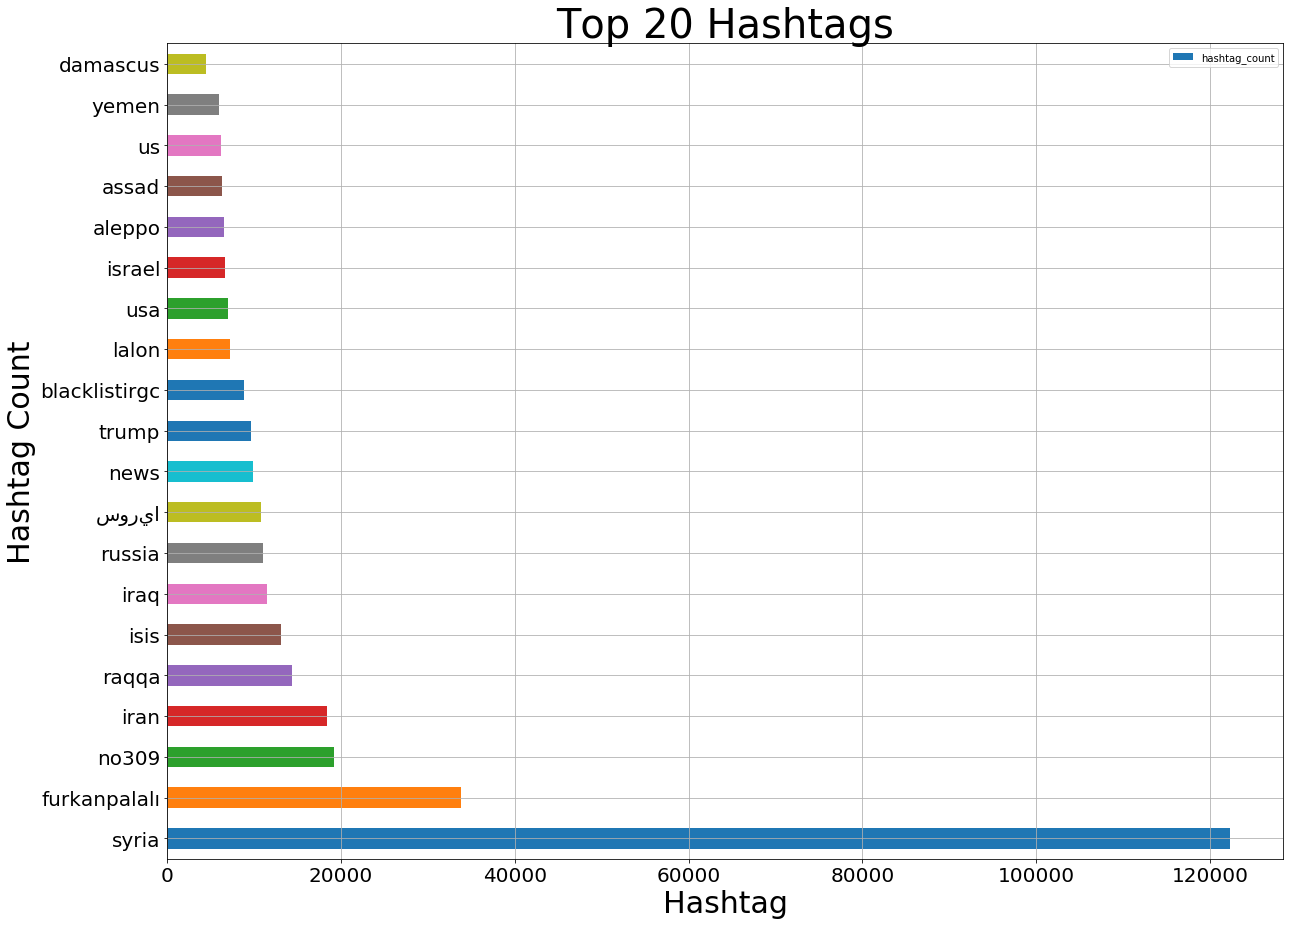

In [315]:
# make dataframe of top hashtags to chart
top_hashtags_df = pandas.DataFrame(top_n_hashtags, columns=['hashtag', 'hashtag_count'])

# make chart
top_hashtags_df.plot(kind='barh', x='hashtag', y='hashtag_count', figsize=(20, 15))
plt.title('Top 20 Hashtags', size = 40)
plt.xlabel('Hashtag', size = 30)
plt.xticks(size=20)
plt.ylabel('Hashtag Count', size = 30)
plt.yticks(size=20)
plt.grid(True)
plt.savefig('/Users/adamstueckrath/Desktop/top_tweet_hashtags.png')
plt.show()


Not surprising that some the top hashtags are "syria", "isis", "iran", and "iraq". This is a great indictation that my data topics are centered around the Syrian war. However, I did notice one of the hashtags is in arabic. I'll discuss later how I plan on handling my data that's in a foreign language.

## Most influential Twitter users

In [112]:
# get most influential twitter users by verified accounts and number of followers 
verified_users_followers_df = pandas.DataFrame(tweets_no_rts_df, columns=['user_screen_name', 'user_name',
                                                                          'user_followers_count', 'user_verified'])

verified_users_followers_df = verified_users_followers_df[verified_users_followers_df['user_verified'] != False]
verified_users_followers_df = verified_users_followers_df.sort_values('user_followers_count', ascending=False)
verified_users_followers_df = verified_users_followers_df.drop_duplicates(subset=['user_screen_name'], keep='last')
verified_users_followers_df = verified_users_followers_df.head(20)


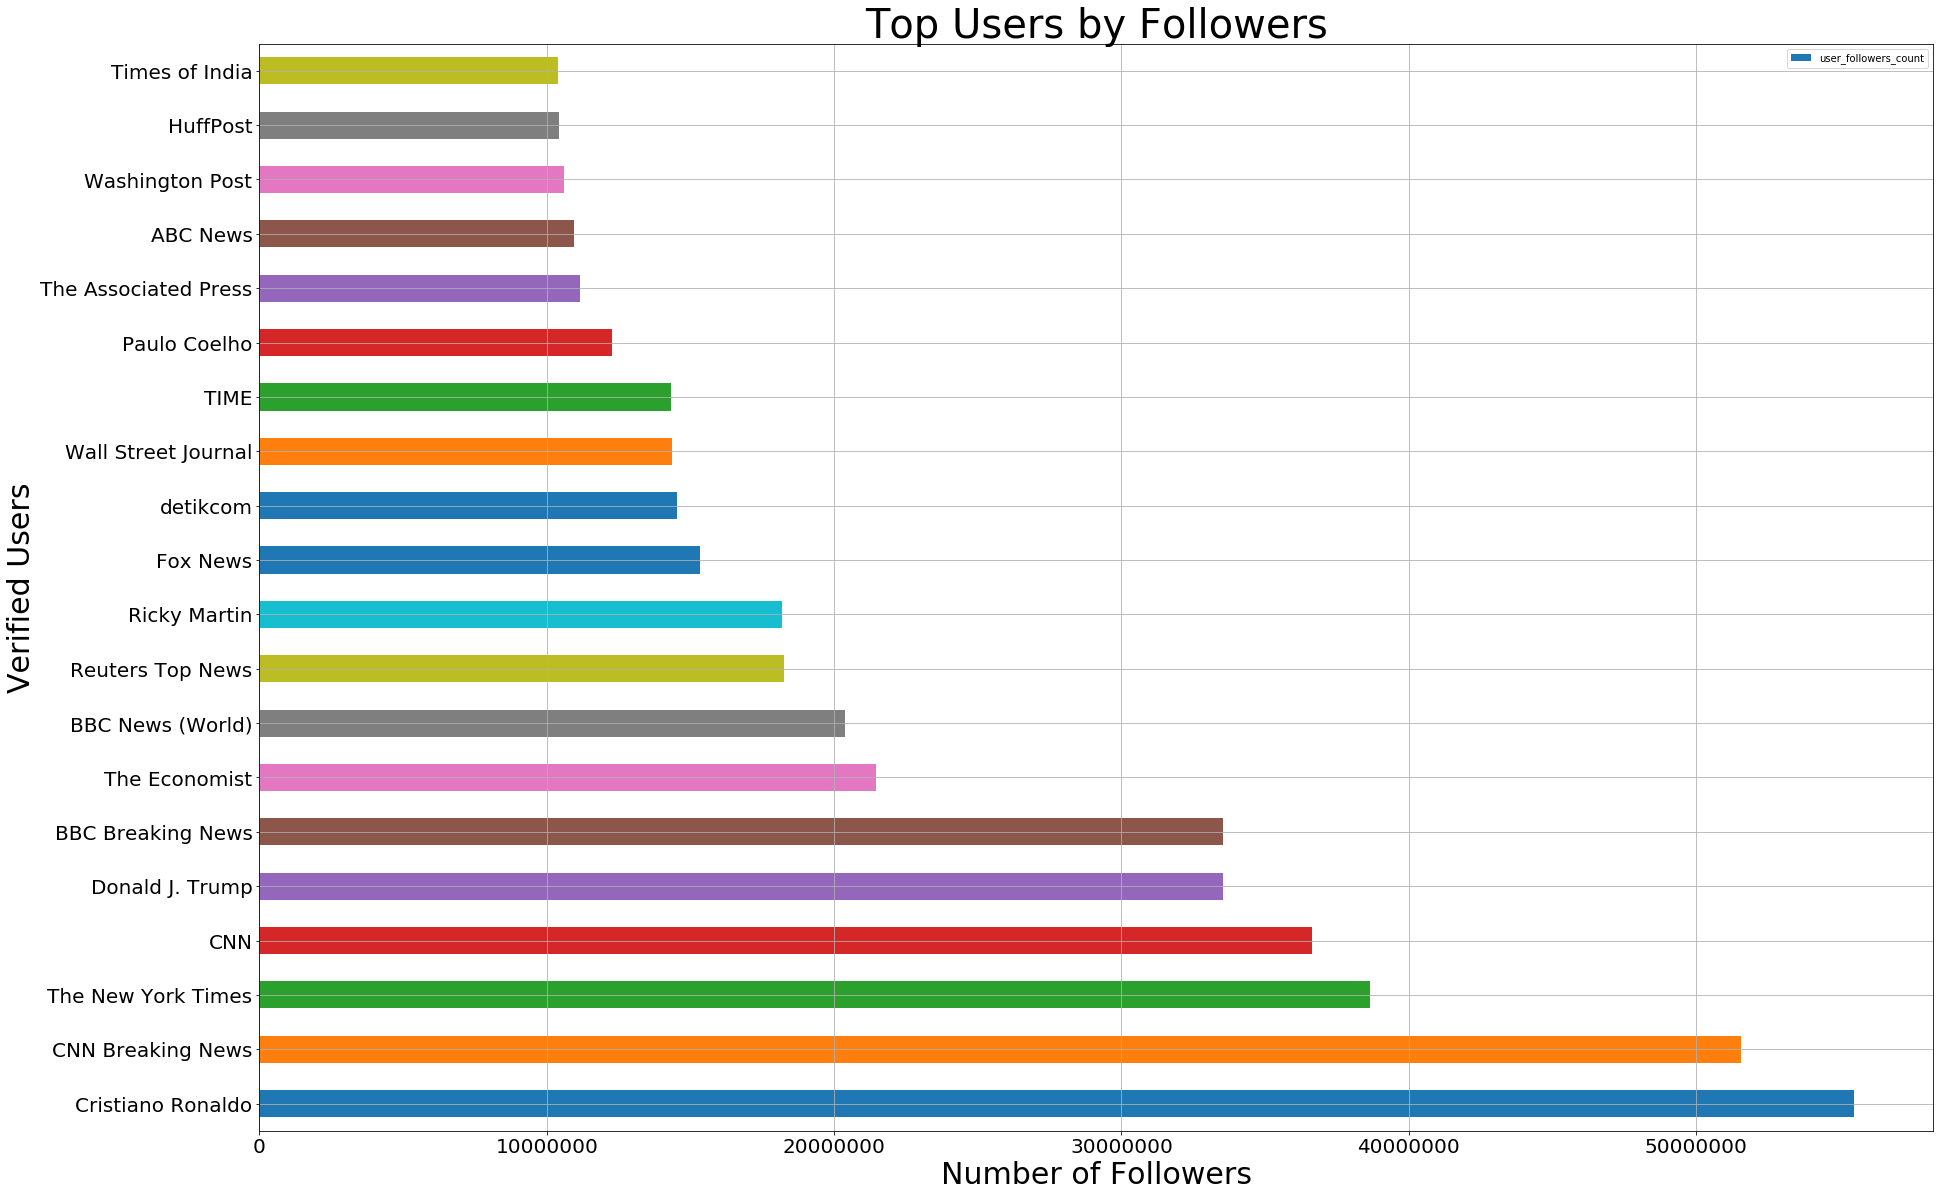

In [320]:
# plot the top n influential users
fig, ax = plt.subplots(figsize=(30,20))
verified_users_followers_df.plot(kind='barh', y="user_followers_count", x="user_name", ax=ax)
plt.title('Top Users by Followers', size = 40) 
plt.xlabel('Number of Followers', size = 30) 
plt.ylabel('Verified Users', size = 30)
plt.xticks(rotation='horizontal', size=20)
plt.yticks(size=20)
plt.ticklabel_format(style='plain', axis='x')
plt.grid(True)
plt.savefig('/Users/adamstueckrath/Desktop/top_tweet_users.png')
plt.show()


## Tweet Media Types

In [322]:
import numpy as np
def media_types(row):
    if row.tweet_media_type:
        return row.tweet_media_type
    elif row.tweet_expanded_url:
        return 'link'
    return 'text'

tweet_media_types_df = pandas.DataFrame(tweets_no_rts_df, columns=['tweet_media_type', 
                                                                   'tweet_expanded_url','tweet_media_url',
                                                                   'tweet_text'])


In [323]:
# tweet_media_types_df.fillna(False, inplace=True)
tweet_media_types_df = tweet_media_types_df
tweet_media_types_df = tweet_media_types_df.replace({np.nan:None})

In [324]:
# tweet_media_types_df['media_type'] = tweet_media_types_df.apply(media_types, axis=1)
tweet_media_types_df['media_type'] = tweet_media_types_df.apply(media_types, axis=1)

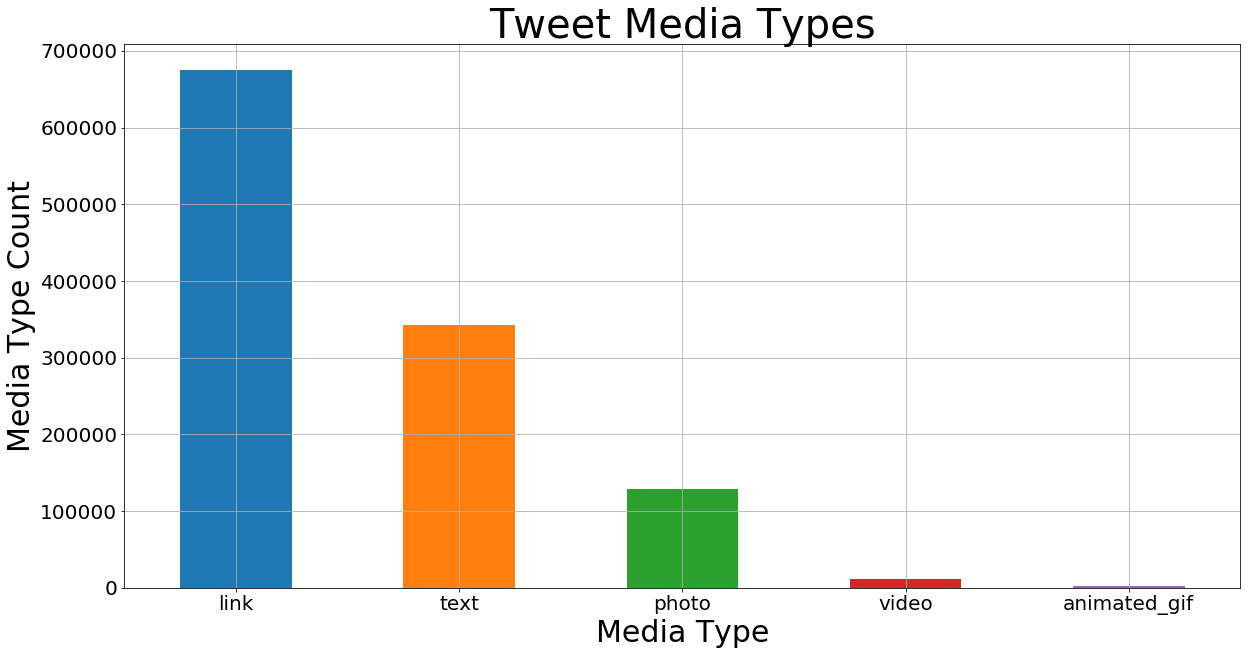

In [325]:
tweet_media_types_values = tweet_media_types_df['media_type'].value_counts()

# make chart
tweet_media_types_values.plot(kind='bar', x='media_type', y='count', figsize=(20, 10))
plt.title('Tweet Media Types', size = 40)
plt.xlabel('Media Type', size = 30)
plt.xticks(rotation='horizontal', size=20)
plt.ylabel('Media Type Count', size = 30)
plt.yticks(size=20)
plt.grid(True)
plt.savefig('/Users/adamstueckrath/Desktop/top_media_types.png')
plt.show()


## Sentiment analysis with textblob
**What is sentiment analysis?**
Sentiment analysis refers to a classification task in the Natural Language Processing (NLP) community, the goal of which is commonly to determine the polarity (positive/negative) of the input text. Whereas subjectivity analysis deals with the detection of private states (opinions, emotions, sentiments, beliefs, speculations), classifying the textual input as objective/subjective. The main parameters defining the scope of a sentiment analysis approach are the target language, domain and media type (traditional or social media).

**What is textblob?**
I'm not an NLP expert, but I recently discovered a library called `TextBlob`. I found it very easy to get started with. You might want to read the docs and see how it suits your project. https://textblob.readthedocs.io/en/dev/index.html

>TextBlob is a Python library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation and more.

Text Blob has a method called sentiment which analyzes the text that is passed through it and calculates:
* Polarity (range[-1.0, 1.0], where -1 is very negative and 1 is very positive)
* Subjectivity (range [0.0, 1.0], where 0.0 is very objective and 1.0 is very subjective).

Does this have any advantage or differences from NLTK?
* I don't have much experience, but I found TextBlob much easier to pick up and use than NLTK.
* It is built on top of NLTK and provides a cleaner API that can help you get your job done quickly.

In [114]:
from textblob import TextBlob
import re

def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [115]:
# get sentiment of english tweets
tweet_sentiment_analysis_df = tweets_no_rts_df[(tweets_no_rts_df.tweet_lang == 'en')]
tweet_sentiment_analysis_df = tweet_sentiment_analysis_df.reset_index(drop=True) 
tweet_sentiment_analysis_df['SentimentAnalysis'] = tweet_sentiment_analysis_df['tweet_text'].apply(analize_sentiment)


In [161]:
# print sentiment analysis values
total_values = len(tweet_sentiment_analysis_df.index)
sentiment_values = tweet_sentiment_analysis_df['SentimentAnalysis'].value_counts().to_dict()
positive_tweets = sentiment_values[1]
neutral_tweets = sentiment_values[0]
negative_tweets = sentiment_values[-1]
print("Percentage of positive tweets: {}%".format(round(positive_tweets*100/total_values)))
print("Percentage of neutral tweets: {}%".format(round(neutral_tweets*100/total_values)))
print("Percentage de negative tweets: {}%".format(round(negative_tweets*100/total_values)))


Percentage of positive tweets: 28%
Percentage of neutral tweets: 52%
Percentage de negative tweets: 20%


In [162]:
sentiment_values['Posivite'] = sentiment_values.pop(1)
sentiment_values['Neutral'] = sentiment_values.pop(0)
sentiment_values['Negative'] = sentiment_values.pop(-1)

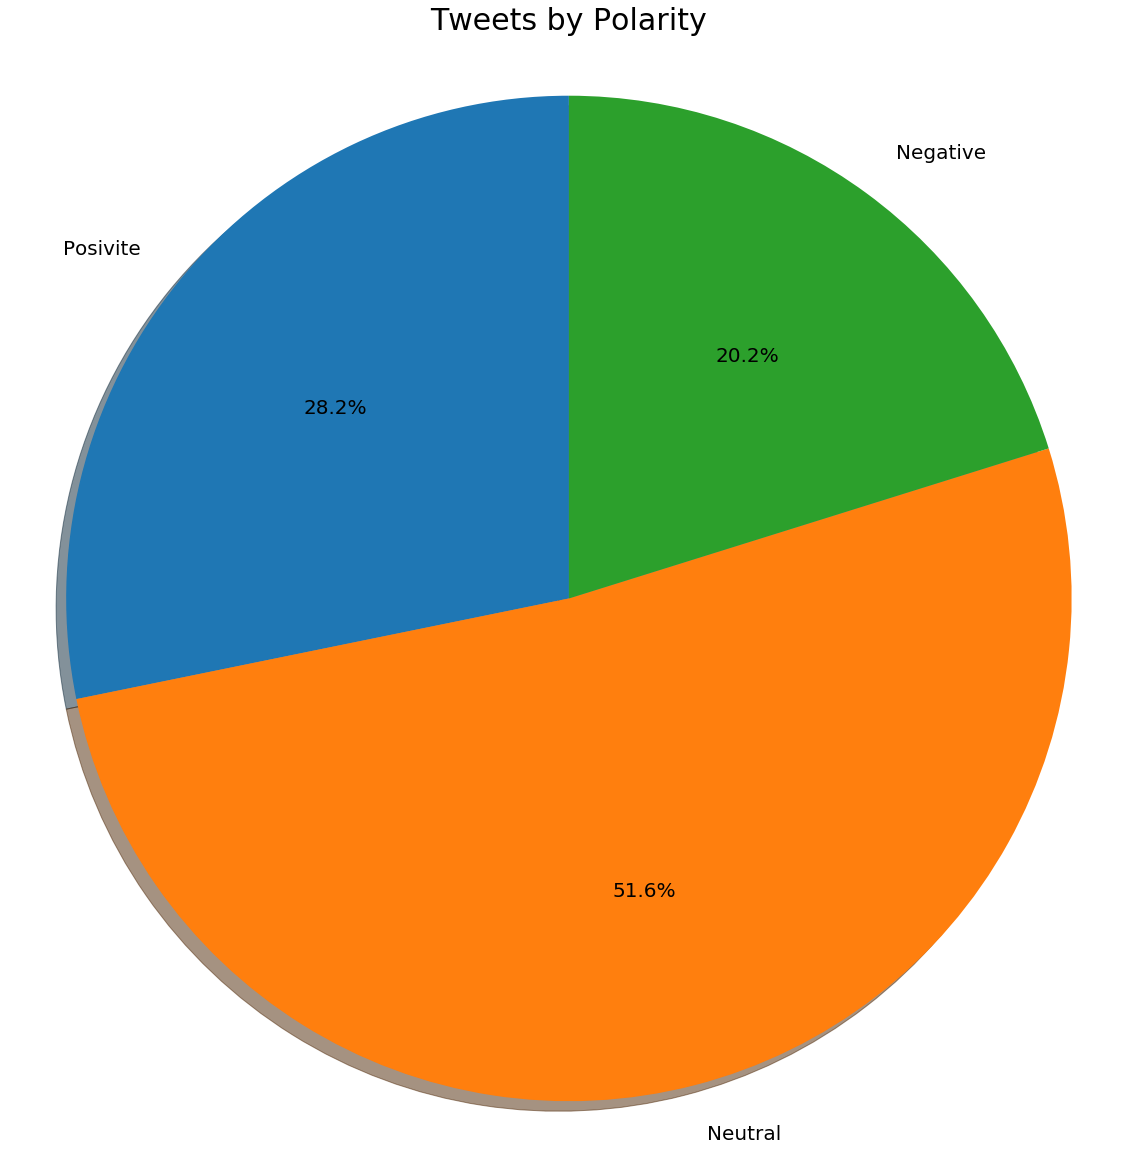

In [326]:
# plot the Polarity of tweets 
fig, ax = plt.subplots(figsize=(20, 20))
ax.pie(sentiment_values.values(), labels=sentiment_values.keys(), autopct='%1.1f%%',
       shadow=True, startangle=90, textprops={'fontsize': 20})
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal') 
plt.title('Tweets by Polarity', size = 30, y=1.02)
plt.savefig('/Users/adamstueckrath/Desktop/sentiment_analysis.png')
plt.show()


For more accurate results I should consider adding the retweets back into my dataset, but dropping any duplicates. An interesting idea would be to analyze the polarity of the tweets from different media types. It might be deterministic that by only considering the tweets from a specific media type, the polarity would result more positive/negative.

## Next steps in my analysis

### Google translate API 
As I mentioned earlier, I noticed that there are hashtags in Arabic. Since my topic, and subsequently dataset, is over an event in the middle east a large subset of my data is probably in another language. To find meaningful results using text processing, I need to translate all of my text data into a single language ( i.e. English). The Google Translation API is very easy to set up and use. However, it is not free so if you're making any API calls, make sure you have taken the steps to estimate how much it will cost. Especially for a large dataset. 

Here is the breakdown of the Google Translation API cost:

It is also worth mentioning that at this current time, Google API is providing a sign-up bonus of $300 which can be applied towards their variety of services. For many of their APIs, including Google Translation API.


In [150]:
# make dataframe of top languages to chart
language_values = tweets_no_rts_df['tweet_lang'].value_counts()[:10]

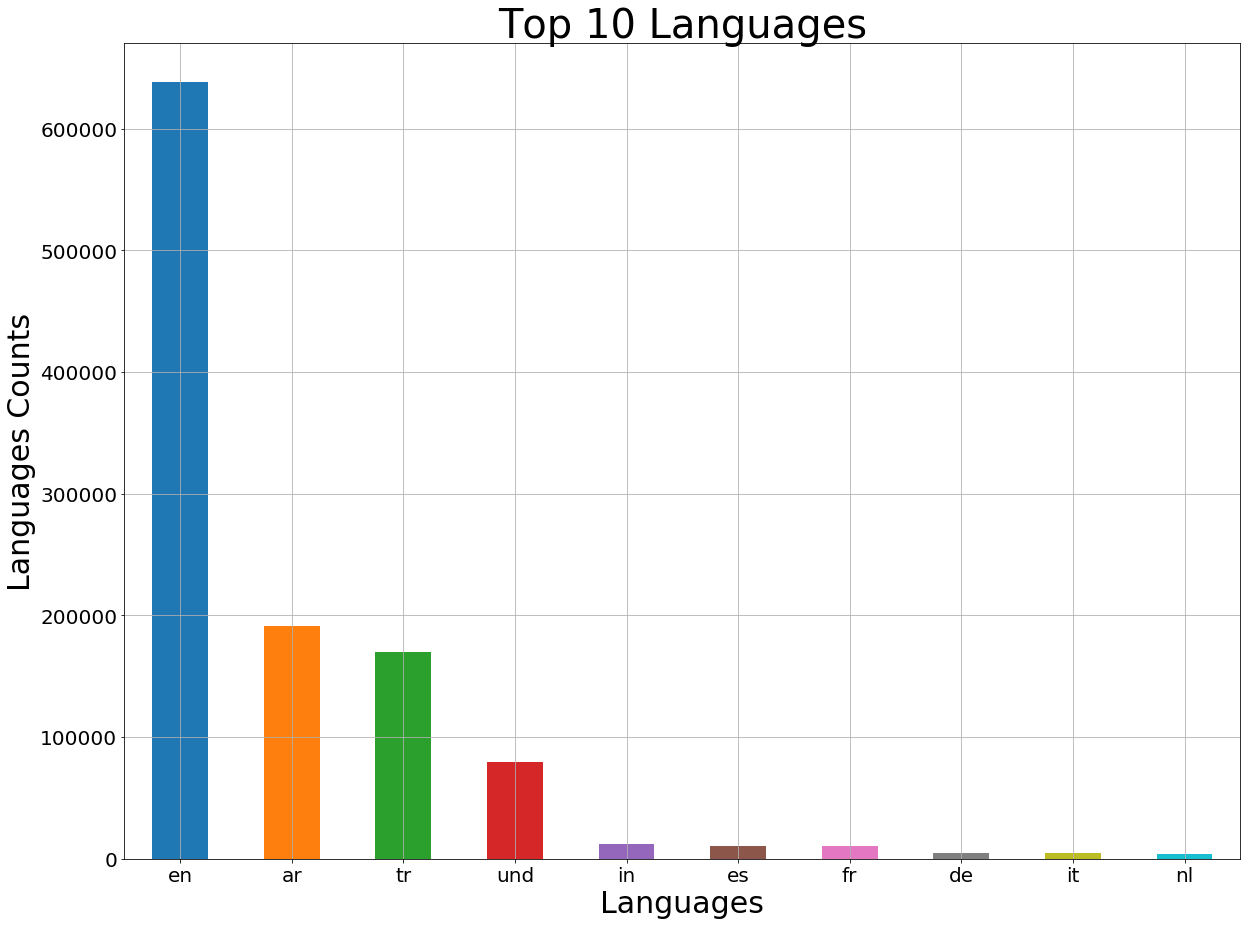

In [327]:
# make chart on top languages
language_values.plot(kind='bar', x='lang', y='count', figsize=(20, 15))
plt.title('Top 10 Languages', size = 40)
plt.xlabel('Languages', size = 30)
plt.xticks(rotation='horizontal', size=20)
plt.ylabel('Languages Counts', size = 30)
plt.yticks(size=20)
plt.grid(True)
plt.savefig('/Users/adamstueckrath/Desktop/top_languages.png')
plt.show()


As you can see, the majority of my data is in English, which is great. However, given my topic is centered in the Middle East, I want to be sure to include that data (e.i. Arabic). I'm still estimating how much it will cost me to translate the non-English text into English, but I hope to keep it around $300. Once I'm ready, here my the code to translate my data.

In [153]:
# translate text with Google Cloud Translate API 
import os
import string
from google.cloud import translate

os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")
def translate_text(text, target='en'):
    """
    Target must be an ISO 639-1 language code.
    https://cloud.google.com/translate/docs/languages
    print(u'Text: {}'.format(result['input']))
    print(u'Translation: {}'.format(result['translatedText']))
    print(u'Detected source language: {}'.format(result['detectedSourceLanguage']))
    """
    translate_client = translate.Client()
    result = translate_client.translate(text, target_language=target)
    return result['translatedText']
